# Analysis of DeepPath Experiments
This notebook documents our analysis of performance results from various experiments ran on DeepPath models

In [1]:
# Packages/Helper Function Import
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import deeppath_parsers as dp

In [2]:
# Directory Constants
output_dir = Path("work/output/")

In [3]:
# Helper function for loading many studies
def load_studies(studies,labels):
    # Parse slide probs
    slide_probs = pd.concat({
        study.stem:pd.DataFrame(dp.parse_slide_probs(study / "auc" / "out2_perSlideStats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    slide_probs["group"] = slide_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    slide_probs["group"].fillna("Control",inplace=True)
    slide_probs["study"] = slide_probs["study"].apply(lambda x: labels[x])
    slide_probs.sort_values(["study","class"],inplace=True)
    # Parse tile probs
    tile_probs =  pd.concat({
        study.stem:pd.DataFrame(dp.parse_tile_probs(study / "out_filename_Stats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    tile_probs["group"] = tile_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    tile_probs["group"].fillna("Control",inplace=True)
    tile_probs["study"] = tile_probs["study"].apply(lambda x: labels[x])
    tile_probs.sort_values(["study","class"],inplace=True)
    #Parse AUCs
    auc = pd.concat({
        study.stem:pd.DataFrame(dp.parse_auc_file(study / "auc_summary.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    auc["group"] = auc["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    auc["group"].fillna("Control",inplace=True)
    auc["study"] = auc["study"].apply(lambda x: labels[x])
    auc.sort_values(["study","class"],inplace=True)
    slide_auc = auc[auc.type=="slide"]
    tile_auc = auc[auc.type=="tile"]
    return slide_probs,tile_probs,slide_auc,tile_auc

## Phase 1 Analyses
Phase 1 analyses the failure modes of the model by pertubing input datasets in various ways

In [4]:
# Phase 1 Study Labels
phase1_labels = {
    "exp_bubbles_20": "Bubbles (20%)",
    "exp_bubbles_100": "Bubbles (100%)",
    "exp_fold_20": "Folds (20%)",
    "exp_illumination_50": "Illumination (50%)",
    "exp_illumination_10": "Illumination (10%)",
    "exp_illumination_100": "Illumination (10%)",
    "exp_illumination_50": "Illumination (50%)",
    "exp_marker_15": "Marker (15%)",
    "exp_marker_80": "Marker (80%)",
    "exp_sectioning_15": "Sectioning (15%)",
    "exp_sectioning_30" : "Sectioning (30%)",
    "phase1_exp": "Unperturbed"
}

phase1_studies = list(output_dir.glob("exp_*_*")) + [output_dir / "phase1_exp"]
phase1_slide_probs, phase1_tile_probs, phase1_slide_auc, phase1_tile_auc = load_studies(phase1_studies,phase1_labels)

Text(0.5, 0.98, 'Phase 1: Slide Average True Probabilities')

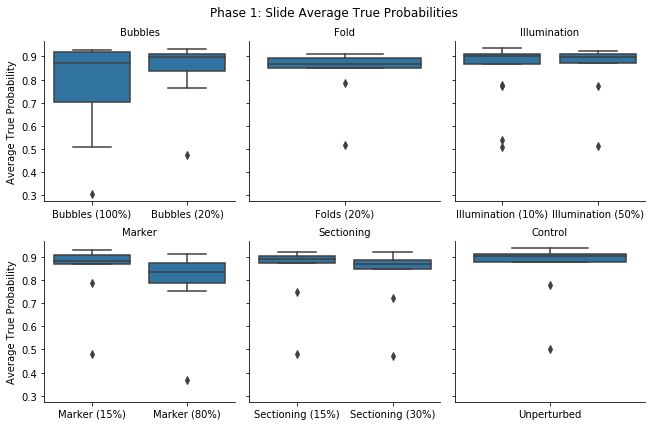

In [5]:
# Average True Prob Overall
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob")
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Slide Average True Probabilities")

Text(0.5, 0.98, 'Phase 1: Slide Average True Probabilities (By Class)')

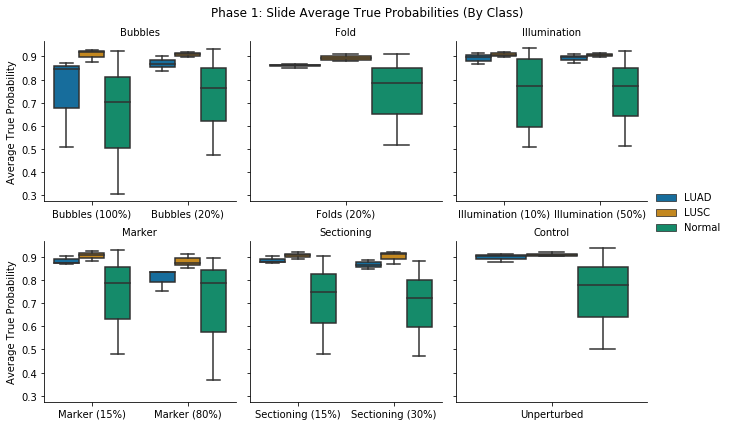

In [6]:
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Slide Average True Probabilities (By Class)")

Text(0.5, 0.98, 'Phase 1: Tile Average True Probabilities (By Class)')

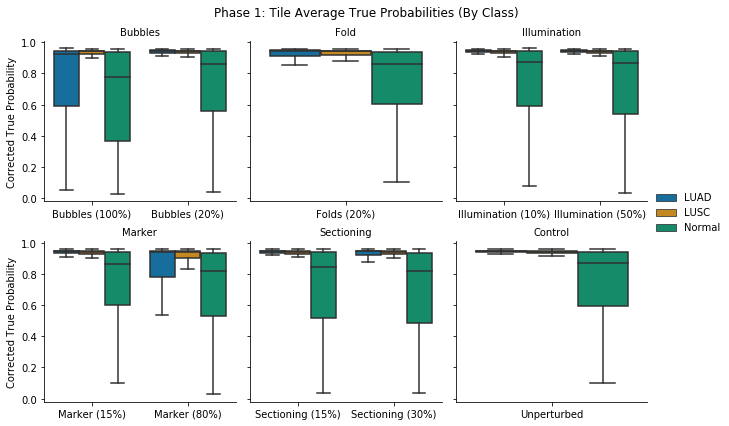

In [7]:
g = sns.FacetGrid(data=phase1_tile_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Tile Average True Probabilities (By Class)")

/Users/jeremykaplan/bin/miniconda3/envs/b590prj/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Phase 1: Per Tile AUC (By Class)')

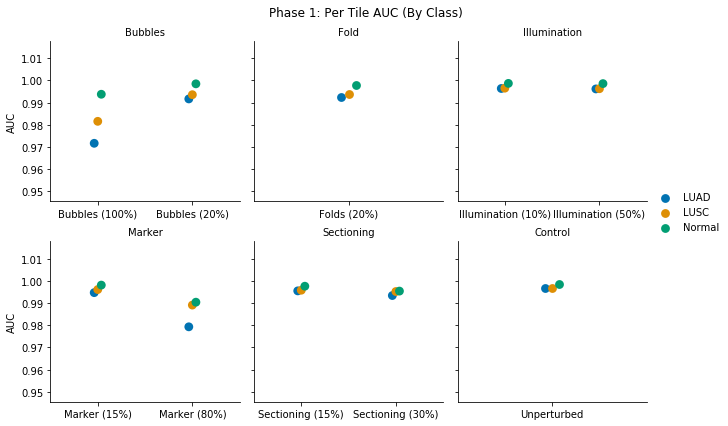

In [8]:
g = sns.FacetGrid(data=phase1_tile_auc,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.pointplot,x="study",y="auc",hue="class",palette="colorblind",join=False,dodge=True)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Per Tile AUC (By Class)")

Text(0.5, 0.98, 'Phase 1: Per Slide AUC (By Class)')

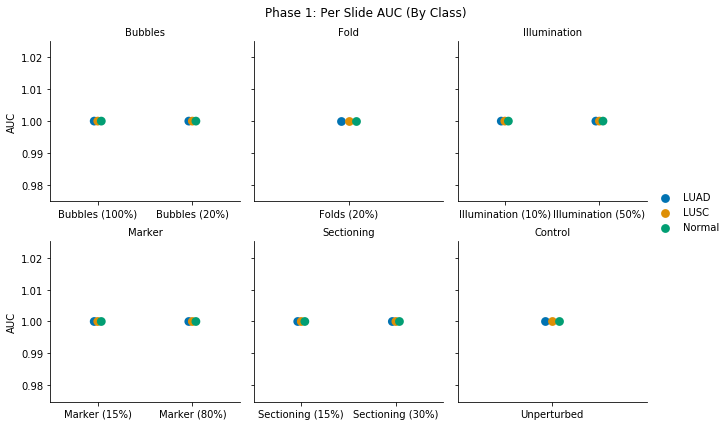

In [9]:
g = sns.FacetGrid(data=phase1_slide_auc,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.pointplot,x="study",y="auc",hue="class",palette="colorblind",join=False,dodge=True)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Per Slide AUC (By Class)")

## Phase 2 Analyses

In [10]:
# Phase 2 Study Labels
phase2_labels = {
    "phase2_gender_female": "Sex: Female",
    "phase2_gender_male": "Sex: Male",
    "phase2_race_asian": "Race: Asian",
    "phase2_race_black": "Race: Black",
    "phase2_race_white": "Race: White"
}
# Load Phase 2 Data
phase2_studies = list(output_dir.glob("phase2_*/"))
phase2_slide_probs, phase2_tile_probs, phase2_slide_auc, phase2_tile_auc = load_studies(phase2_studies,phase2_labels)


Text(0, 0.5, 'Average Positive Probability (True Class)')

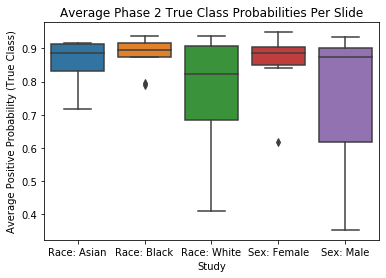

In [11]:
# Average True Class Probability
fig = sns.boxplot(x=phase2_slide_probs["study"],y=phase2_slide_probs["true_av_prob"])
fig.set_title("Average Phase 2 True Class Probabilities Per Slide")
fig.set_xlabel("Study")
fig.set_ylabel("Average Positive Probability (True Class)")

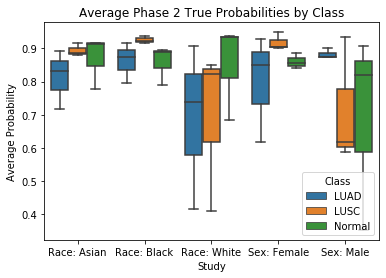

In [12]:
# Av true class probability by class
fig = sns.boxplot(
    data=phase2_slide_probs[["study","class","true_av_prob"]],
    x="study",
    y="true_av_prob",
    hue="class"
)
fig.set_xlabel("Study")
fig.set_ylabel("Average Probability")
fig.set_title("Average Phase 2 True Probabilities by Class")
plt.legend(title="Class",loc=4)

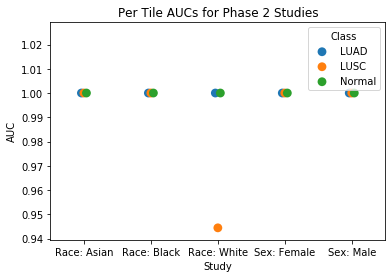

In [13]:
# Tile level AUCs
fig = sns.pointplot(
    data=phase2_slide_auc,
    x="study",
    y="auc",
    hue="class",
    join=False,
    dodge=True
    #yerr=phase2_auc_tile[["ci_lower","ci_upper"]].values.T
)
fig.set_title("Per Tile AUCs for Phase 2 Studies")
fig.set_xlabel("Study")
fig.set_ylabel("AUC")
plt.legend(title="Class")

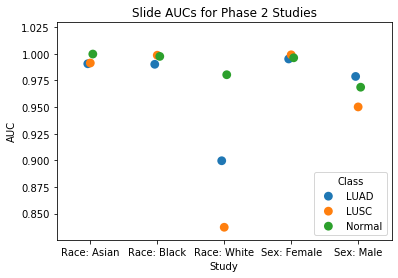

In [14]:
# Slide level AUCs
fig = sns.pointplot(
    data=phase2_tile_auc,
    x="study",
    y="auc",
    hue="class",
    join=False,
    dodge=True
    #yerr=phase2_auc_tile[["ci_lower","ci_upper"]].values.T
)
fig.set_title("Slide AUCs for Phase 2 Studies")
fig.set_xlabel("Study")
fig.set_ylabel("AUC")
plt.legend(title="Class",loc=4)

AxesSubplot(0.125,0.125;0.775x0.755)


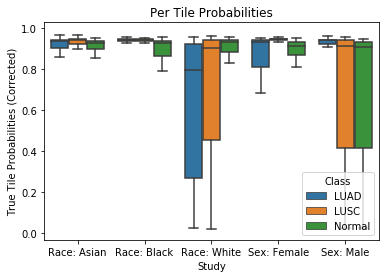

In [15]:
# Tile Probabilities by class
fig = sns.boxplot(
    data=phase2_tile_probs,
    x="study",
    y="corrected_true_prob",
    hue="class",
    whis=1,
    fliersize=0.001
)
fig.set_xlabel("Study")
fig.set_ylabel("True Tile Probabilities (Corrected)")
fig.set_title(f"Per Tile Probabilities")
plt.legend(title="Class",loc=4)
print(fig)